
See readme for information about this file.

Ethoflow: computer vision and artificial intelligence-based software for automatic behavior analysis
v 1.0

DOI: [10.1101/2020.07.23.218255](https://www.biorxiv.org/content/10.1101/2020.07.23.218255v1)
License CC BY-NC-ND 4.0

@developer: [Rodrigo Cupertino Bernardes](https://www.researchgate.net/profile/Rodrigo_Cupertino_Bernardes)


<marquee style='width: 30%; color: blue;'><b>
<img src="icon/logo_ethoflow.png" alt="Ethoflow" width="200"
         height="80"></b></marquee>


# Inspect Trained Model

Get the model saved in "train_mask_rcnn/Mask_RCNN/logs" and upload to "~/colab/train_mask_rcnn/logs"

In [17]:
ls

 O volume na unidade A ‚ hd interno
 O N£mero de S‚rie do Volume ‚ 569F-EE18

 Pasta de A:\documents\Mega\Ethoflow_git\train_mask_rcnn

08/08/2020  16:15    <DIR>          .
08/08/2020  16:15    <DIR>          ..
08/08/2020  14:05    <DIR>          .ipynb_checkpoints
08/08/2020  16:15           661.419 Copy of maskrcnn_custom_tf_colab.ipynb
07/08/2020  16:47    <DIR>          logs
08/08/2020  15:13    <DIR>          Mask_RCNN
               1 arquivo(s)        661.419 bytes
               5 pasta(s)   542.772.862.976 bytes dispon¡veis


In [2]:
import os
os.getcwd()

'A:\\documents\\Mega\\Ethoflow\\Ethoflow_v1\\train_mask_rcnn'

In [5]:

%cd "Mask_RCNN"

import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import scipy
import bee

# Root directory of the project
%cd ".."

ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  

custom_WEIGHTS_PATH = os.path.join(ROOT_DIR, "logs/mask_rcnn_bee_0024.h5")

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

config = bee.BeeConfig()
custom_DIR = os.path.join(ROOT_DIR, "Mask_RCNN/dataset")

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()


# Device to load the neural network on.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
  

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Load weights
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

from importlib import reload
reload(visualize)

###############
%cd "Mask_RCNN"
# Load validation dataset
dataset = bee.BeeDataset()
dataset.load_bee(custom_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

[WinError 2] O sistema não pode encontrar o arquivo especificado: 'Mask_RCNN'
A:\documents\Mega\Ethoflow_git\train_mask_rcnn\Mask_RCNN
A:\documents\Mega\Ethoflow_git\train_mask_rcnn


Re-starting from epoch 24
A:\documents\Mega\Ethoflow_git\train_mask_rcnn\Mask_RCNN
Images: 248
Classes: ['BG', 'bee']


image ID: bee.948.jpg (200) A:/documents/Mega/Ethoflow_git/train_mask_rcnn/Mask_RCNN/dataset/val/948.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  120.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (6,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (6, 4)                min:  236.00000  max:  888.00000  int32
gt_mask                  shape: (1024, 1024, 6)       min:    0.00000  max:    1.00000  bool


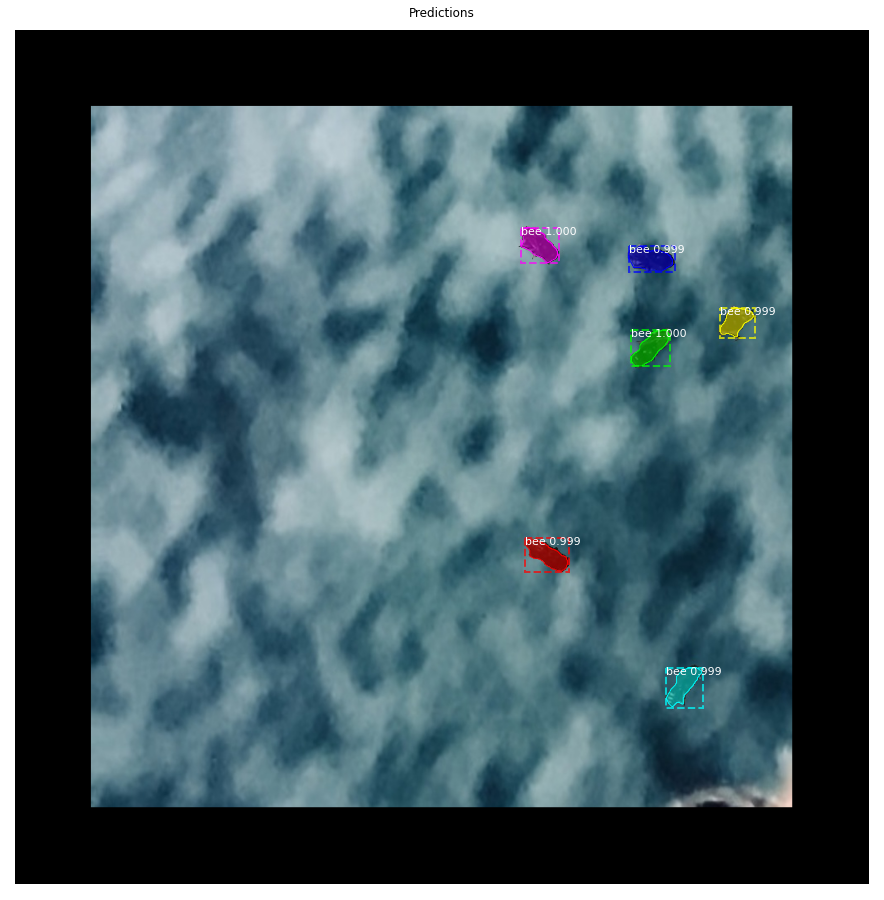

In [2]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

#plt.savefig('file.eps',format='eps',dpi=300 )

In [3]:
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
        
    print("mean AP @ IoU=50: ", np.mean(APs))
    print("median AP @ IoU=50: ", np.median(APs))
    print("se AP @ IoU=50: ", scipy.stats.sem(APs))
    
    import seaborn as sns
 
    ax=sns.kdeplot(APs, shade=True)

    plt.xlabel('AP', fontsize=16)
    plt.ylabel('Density', fontsize=16)

    ax.tick_params(direction='out')
    
    return APs


## Compute average precision

mean AP @ IoU=50:  0.8616666696965695
median AP @ IoU=50:  1.0
se AP @ IoU=50:  0.050162017113812345


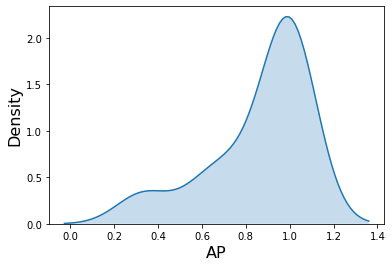

In [6]:
#image_ids = dataset.image_ids[0:2] # To get specific images

n=20
image_ids = np.random.choice(dataset.image_ids, n) #choose n random images to compute mAP (Mean Average Precision)"
APS=compute_batch_ap(image_ids)